# Object Detection Task: SSD
Code adapted from: https://colab.research.google.com/drive/1wTMIrJhYsQdq_u7ROOkf0Lu_fsX5Mu8a

In [ ]:
# mount google drive to access files
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# If you forked the repo, you can replace the link.
repo_url = 'https://github.com/roboflow-ai/tensorflow-object-detection-faster-rcnn'

# Number of training steps - 1000 will train very quickly, but more steps will increase accuracy.
num_steps = 50000  # 200000 to improve, 5000 is 25 mins on gpu

# Number of evaluation steps.
num_eval_steps = 50

MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 12
    },
    'ssd_inception_v2': { # <---- We will this model
        'model_name': 'ssd_inception_v2_coco_2018_01_28',
        'pipeline_file': 'ssd_inception_v2_coco.config',
        'batch_size': 12
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 12
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
        'batch_size': 8
    }
}

# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
selected_model = 'ssd_inception_v2'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

In [ ]:
# use TF 1.x for Object Detection APIs
%tensorflow_version 1.x

## Clone the tensorflow-object-detection repository or your fork.

In [ ]:
import os

%cd /content

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}
!git pull

/content
Cloning into 'tensorflow-object-detection-faster-rcnn'...
remote: Enumerating objects: 885, done.
remote: Total 885 (delta 0), reused 0 (delta 0), pack-reused 885
Receiving objects: 100% (885/885), 24.83 MiB | 39.00 MiB/s, done.
Resolving deltas: 100% (428/428), done.
/content/tensorflow-object-detection-faster-rcnn
Already up to date.


## Install required packages

In [ ]:
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git

!pip install tf_slim

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

!pip install lvis

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

!python object_detection/builders/model_builder_test.py

/content
     |████████████████████████████████| 358kB 35.2MB/s 
Selecting previously unselected package python-bs4.
(Reading database ... 160706 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to unp

## Prepare tfrecord files

In [ ]:
%cd /content/tensorflow-object-detection-faster-rcnn/data

/content/tensorflow-object-detection-faster-rcnn/data


In [ ]:
# load and unzip data from gdrive
!unzip '/content/gdrive/MyDrive/DL and CNN/Synthetic Fruit.v1-raw.voc.zip'

In [ ]:
%cd {repo_dir_path}
# remove old xml to csv py
!rm /content/tensorflow-object-detection-faster-rcnn/xml_to_csv.py
# use fixed custom script
!cp '/content/gdrive/MyDrive/DL and CNN/xml_to_csv.py' .

/content/tensorflow-object-detection-faster-rcnn


In [ ]:
%cd {repo_dir_path}

# Convert train folder annotation xml files to a single csv file,
# generate the `label_map.pbtxt` file to `data/` directory as well.
#-->
!python xml_to_csv.py -i data/train -o data/annotations/train_labels.csv -l data/annotations

# Convert test folder annotation xml files to a single csv.
#-->
!python xml_to_csv.py -i data/valid -o data/annotations/test_labels.csv

# Generate `train.record`
#-->
!python generate_tfrecord.py --csv_input=data/annotations/train_labels.csv --output_path=data/annotations/train.record --img_path=data/train --label_map data/annotations/label_map.pbtxt

# Generate `test.record`
#-->
!python generate_tfrecord.py --csv_input=data/annotations/test_labels.csv --output_path=data/annotations/test.record --img_path=data/valid --label_map data/annotations/label_map.pbtxt

/content/tensorflow-object-detection-faster-rcnn
Successfully converted xml to csv.
Generate `data/annotations/label_map.pbtxt`
Successfully converted xml to csv.


W0517 21:18:33.951593 140446899165056 module_wrapper.py:139] From generate_tfrecord.py:107: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0517 21:18:34.825238 140446899165056 module_wrapper.py:139] From generate_tfrecord.py:53: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/tensorflow-object-detection-faster-rcnn/data/annotations/train.record


W0517 21:18:40.943357 140113575233408 module_wrapper.py:139] From generate_tfrecord.py:107: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0517 21:18:41.097009 140113575233408 module_wrapper.py:139] From generate_tfrecord.py:53: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Succes

In [ ]:
# NOTE: Update these TFRecord names from "cells" and "cells_label_map" to your files!
test_record_fname = '/content/tensorflow-object-detection-faster-rcnn/data/annotations/test.record'
train_record_fname = '/content/tensorflow-object-detection-faster-rcnn/data/annotations/train.record'
label_map_pbtxt_fname = '/content/tensorflow-object-detection-faster-rcnn/data/annotations/label_map.pbtxt'

## Download base model

In [ ]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research


In [ ]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research/pretrained_model
total 197M
drwxr-xr-x  3 345018 5000 4.0K Feb  1  2018 .
drwxr-xr-x 23 root   root 4.0K May 17 21:18 ..
-rw-r--r--  1 345018 5000   77 Feb  1  2018 checkpoint
-rw-r--r--  1 345018 5000  98M Feb  1  2018 frozen_inference_graph.pb
-rw-r--r--  1 345018 5000  96M Feb  1  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 345018 5000  18K Feb  1  2018 model.ckpt.index
-rw-r--r--  1 345018 5000 3.5M Feb  1  2018 model.ckpt.meta
-rw-r--r--  1 345018 5000 4.0K Feb  1  2018 pipeline.config
drwxr-xr-x  3 345018 5000 4.0K Feb  1  2018 saved_model


In [ ]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

## Configuring a Training Pipeline

In [ ]:
import os
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [ ]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [ ]:
import re

num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

In [ ]:
!cat {pipeline_fname}

# SSD with Inception v2 configuration for MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 63
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect

In [ ]:
# save checkpoint to google drive
#model_dir = 'training/'
model_dir = '/content/gdrive/MyDrive/DL'
# Optionally remove content in output model directory to fresh start.
#!rm -rf {model_dir}
os.makedirs(model_dir, exist_ok=True)

## Train the model

In [ ]:
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

W0517 21:18:51.046207 139919745091456 model_lib.py:812] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: 50000
I0517 21:18:51.046417 139919745091456 config_util.py:552] Maybe overwriting train_steps: 50000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0517 21:18:51.046537 139919745091456 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
I0517 21:18:51.046619 139919745091456 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0517 21:18:51.046700 139919745091456 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0517 21:18:51.046802 139919745091456 model_lib.py:828] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
INFO:tensorflow:create_estimator_and_inputs: use_tpu False, export_to

In [ ]:
!ls {model_dir}

'Assignment 2'
 checkpoint
 eval_0
 events.out.tfevents.1621016083.6de91af17e27
 events.out.tfevents.1621178860.a46a473308c6
 events.out.tfevents.1621286348.03a0d0d8043f
 export
 graph.pbtxt
 model.ckpt-42346.data-00000-of-00001
 model.ckpt-42346.index
 model.ckpt-42346.meta
 model.ckpt-44348.data-00000-of-00001
 model.ckpt-44348.index
 model.ckpt-44348.meta
 model.ckpt-46692.data-00000-of-00001
 model.ckpt-46692.index
 model.ckpt-46692.meta
 model.ckpt-48672.data-00000-of-00001
 model.ckpt-48672.index
 model.ckpt-48672.meta
 model.ckpt-50000.data-00000-of-00001
 model.ckpt-50000.index
 model.ckpt-50000.meta


## Exporting a Trained Inference Graph

In [ ]:
import re
import numpy as np

output_directory = './fine_tuned_model'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

/content/gdrive/MyDrive/DL/model.ckpt-50000
Instructions for updating:
Please use `layer.__call__` method instead.
W0517 23:38:46.161764 140047511345024 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tf_slim/layers/layers.py:2802: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0517 23:38:48.836306 140047511345024 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0517 23:38:48.884746 140047511345024 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0517 23:38:48.926595 140047511345024 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
I

In [ ]:
!ls {output_directory}

checkpoint			model.ckpt.index  saved_model
frozen_inference_graph.pb	model.ckpt.meta
model.ckpt.data-00000-of-00001	pipeline.config


## Download the model .pb file

In [ ]:
import os

pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)

In [ ]:
!ls -alh {pb_fname}

-rw-r--r-- 1 root root 84M May 17 23:39 /content/models/research/fine_tuned_model/frozen_inference_graph.pb


## Download Model to Google Drive

In [ ]:
# incase local download doesnt work
from shutil import copyfile
copyfile(pb_fname, '/content/gdrive/MyDrive/DL and CNN/Assignment 2/frozen_inference_graph.pb')
copyfile(label_map_pbtxt_fname, '/content/gdrive/MyDrive/DL and CNN/Assignment 2/label_map.pbtxt')

'/content/gdrive/MyDrive/DL and CNN/Assignment 2/label_map.pbtxt'

## Run inference test

In [ ]:
# optionally, load frozen detection graph
pb_fname = '/content/gdrive/MyDrive/DL and CNN/Assignment 2/frozen_inference_graph.pb'

In [ ]:
# optionally, remove the TFRecord and cells_label_map.pbtxt from
# the test directory so it is only raw images
#%cd {repo_dir_path}
#%cd data
#%rm -r data/valid
#
# put test images into test folder
#!unzip '/content/gdrive/MyDrive/DL and CNN/Synthetic Fruit.v1-raw.coco.zip' "valid/*.jpg" -d ./

In [ ]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  os.path.join(repo_dir_path, "data/valid")

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

['/content/tensorflow-object-detection-faster-rcnn/data/valid/984_jpg.rf.f86c83994721c5b65937b78df5ff94f2.jpg', '/content/tensorflow-object-detection-faster-rcnn/data/valid/314_jpg.rf.eb22cfb0bbb8d33d133fc66a2686f731.jpg', '/content/tensorflow-object-detection-faster-rcnn/data/valid/734_jpg.rf.1e489ffa03bc4a9fb433019164b45ee7.xml', '/content/tensorflow-object-detection-faster-rcnn/data/valid/249_jpg.rf.66172f449055c5cec172c470b603375c.jpg', '/content/tensorflow-object-detection-faster-rcnn/data/valid/578_jpg.rf.cea4caf59b3232fe1caf0573271f29f7.xml', '/content/tensorflow-object-detection-faster-rcnn/data/valid/235_jpg.rf.e9ec9368033f05c2d718ddc387f09aee.jpg', '/content/tensorflow-object-detection-faster-rcnn/data/valid/301_jpg.rf.0911e2acfbd6ecc388637aadfade4207.xml', '/content/tensorflow-object-detection-faster-rcnn/data/valid/968_jpg.rf.250b9baadbfaad625829924f97eccd9f.xml', '/content/tensorflow-object-detection-faster-rcnn/data/valid/504_jpg.rf.1d1322f199afe7d613bc527ffc3e4c0a.jpg', 

In [ ]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

/content/models/research/object_detection


In [ ]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [ ]:
# This is needed to display the images.
%matplotlib inline

/content/tensorflow-object-detection-faster-rcnn/data/valid/984_jpg.rf.f86c83994721c5b65937b78df5ff94f2.jpg


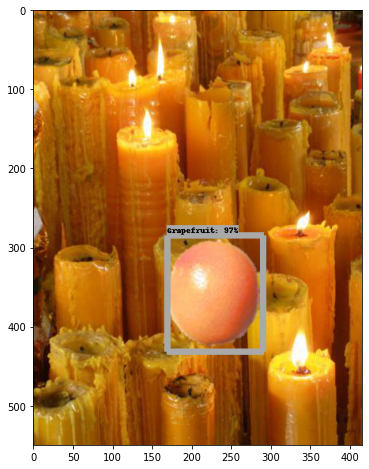

/content/tensorflow-object-detection-faster-rcnn/data/valid/314_jpg.rf.eb22cfb0bbb8d33d133fc66a2686f731.jpg


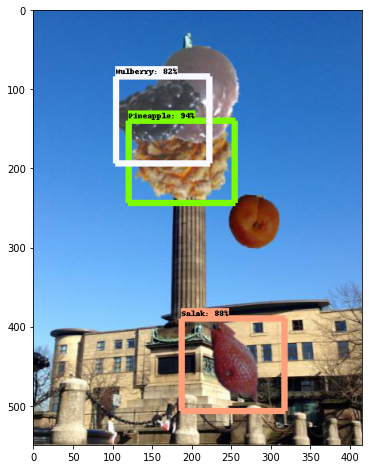

/content/tensorflow-object-detection-faster-rcnn/data/valid/249_jpg.rf.66172f449055c5cec172c470b603375c.jpg


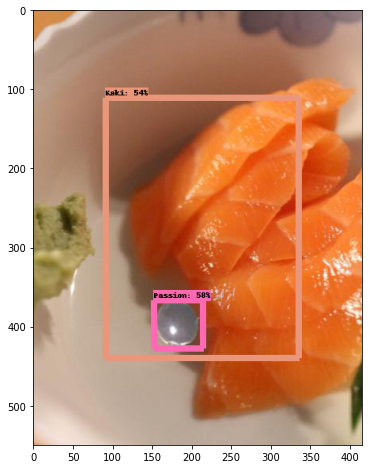

/content/tensorflow-object-detection-faster-rcnn/data/valid/235_jpg.rf.e9ec9368033f05c2d718ddc387f09aee.jpg


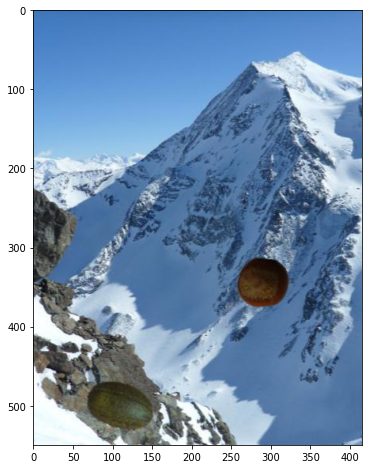

/content/tensorflow-object-detection-faster-rcnn/data/valid/504_jpg.rf.1d1322f199afe7d613bc527ffc3e4c0a.jpg


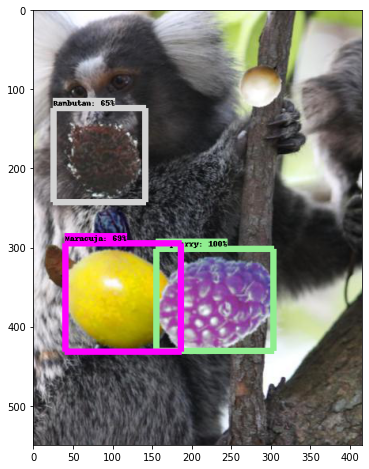

/content/tensorflow-object-detection-faster-rcnn/data/valid/922_jpg.rf.d0ff28ccc24847bdf2065d76374164f0.jpg


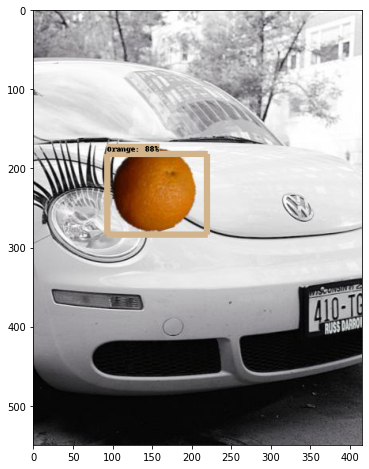

/content/tensorflow-object-detection-faster-rcnn/data/valid/333_jpg.rf.649b79bdd9aba542879ce1ec59796889.jpg


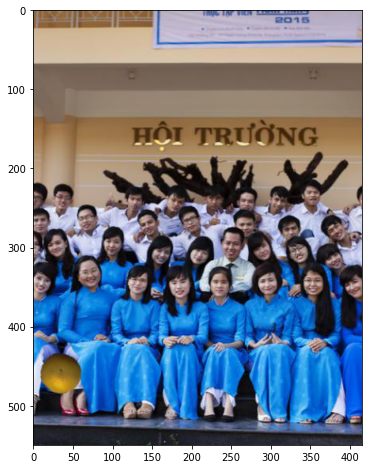

/content/tensorflow-object-detection-faster-rcnn/data/valid/647_jpg.rf.b3f1706f68b1decbe84a46c96e02d942.jpg


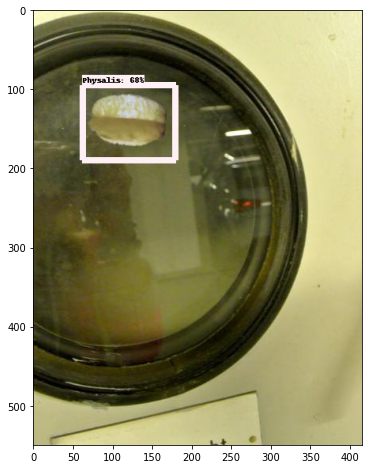

/content/tensorflow-object-detection-faster-rcnn/data/valid/666_jpg.rf.fbcccdd2c595279ca6f0b749504fb1fa.jpg


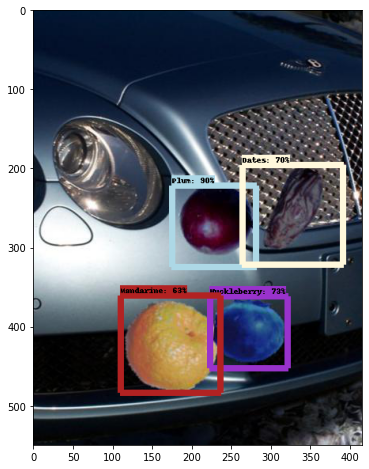

/content/tensorflow-object-detection-faster-rcnn/data/valid/573_jpg.rf.f7b2b8f07b1e1bc75fd3991a042c917e.jpg


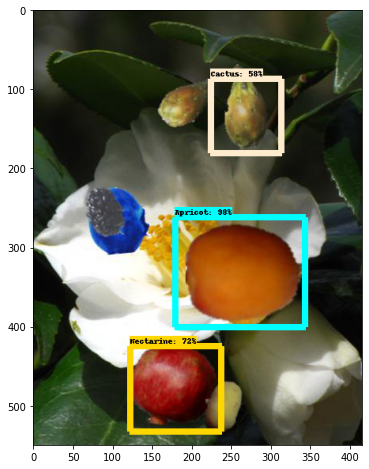

/content/tensorflow-object-detection-faster-rcnn/data/valid/991_jpg.rf.91b82ac67a9214f548ee2f210c52e516.jpg


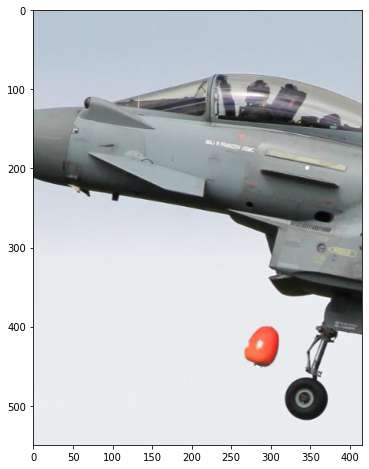

/content/tensorflow-object-detection-faster-rcnn/data/valid/153_jpg.rf.538134f6d3759415f894071dd680b1a1.jpg


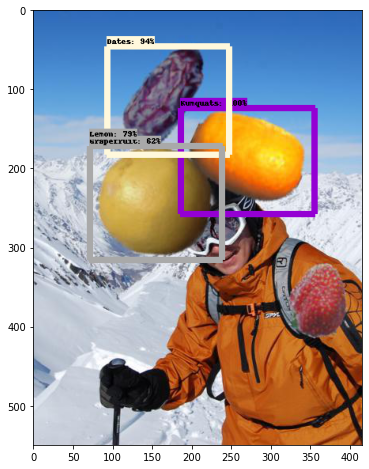

/content/tensorflow-object-detection-faster-rcnn/data/valid/203_jpg.rf.8d31e6e83ac3b304b0302b40ab69b7c4.jpg


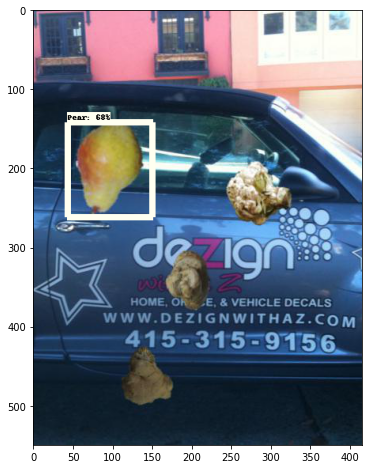

/content/tensorflow-object-detection-faster-rcnn/data/valid/258_jpg.rf.3d3648e094e5ecacfcbaa0520e065c7b.jpg


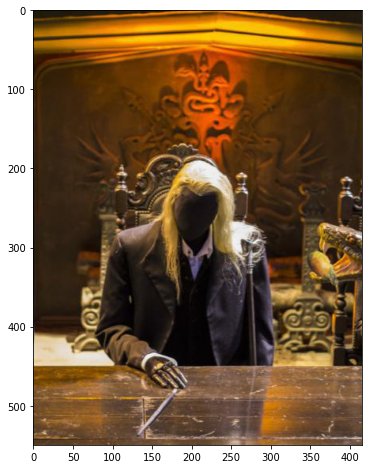

/content/tensorflow-object-detection-faster-rcnn/data/valid/859_jpg.rf.e3c193b8827abd81a877b4f04fb70f34.jpg


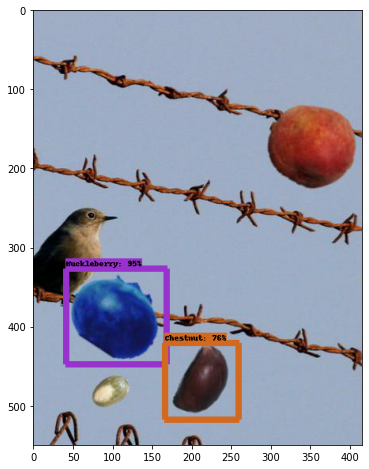

/content/tensorflow-object-detection-faster-rcnn/data/valid/650_jpg.rf.ba8b0bbf56f61169e06e18d8b5473f5a.jpg


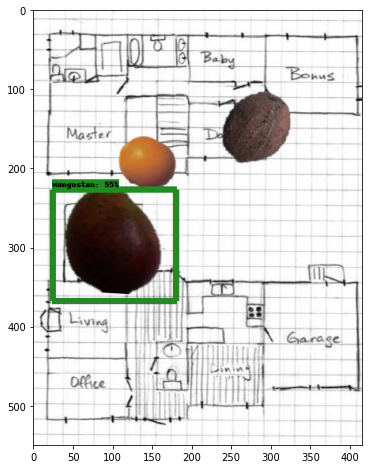

/content/tensorflow-object-detection-faster-rcnn/data/valid/24_jpg.rf.5a09de388a775a369acb014ce4d613d0.jpg


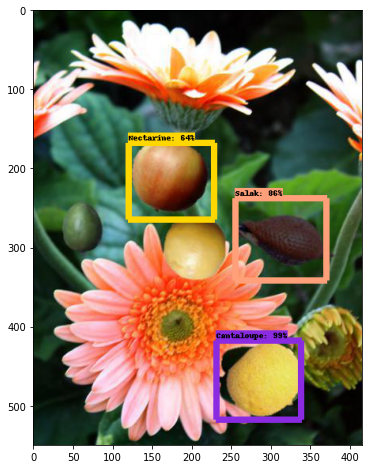

/content/tensorflow-object-detection-faster-rcnn/data/valid/740_jpg.rf.b7d0c8984d43b13d6ec466fe1f05ab00.jpg


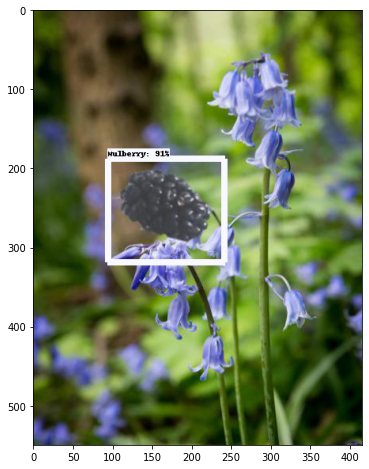

/content/tensorflow-object-detection-faster-rcnn/data/valid/131_jpg.rf.888ec39933ddcb4c8922264cc8831d16.jpg


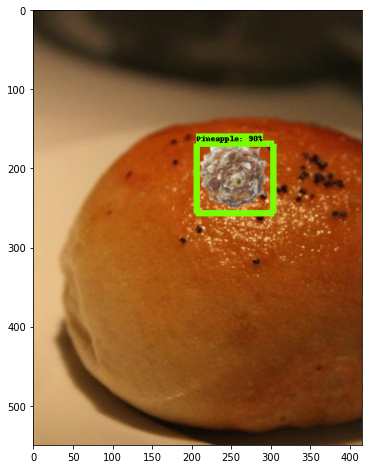

/content/tensorflow-object-detection-faster-rcnn/data/valid/612_jpg.rf.102db4fbceae850c74fd74360b128fdf.jpg


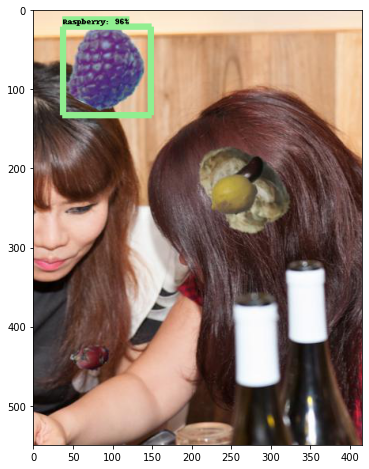

/content/tensorflow-object-detection-faster-rcnn/data/valid/790_jpg.rf.72ec8b9aa3f736c5473071a50ce514b3.jpg


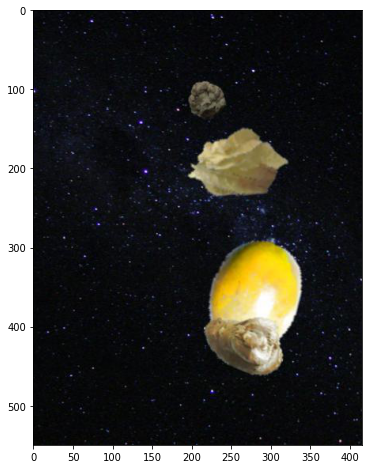

/content/tensorflow-object-detection-faster-rcnn/data/valid/952_jpg.rf.ee0478a0344f121190cecfcd22228063.jpg


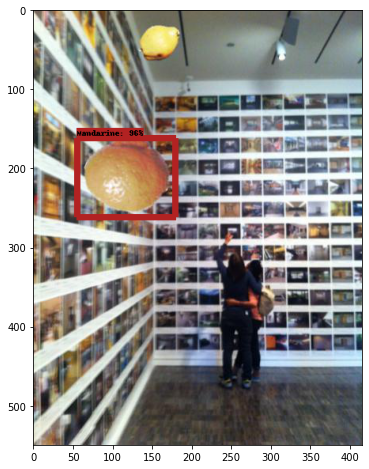

/content/tensorflow-object-detection-faster-rcnn/data/valid/174_jpg.rf.6af7cd9145ff71f501227c14e0fde642.jpg


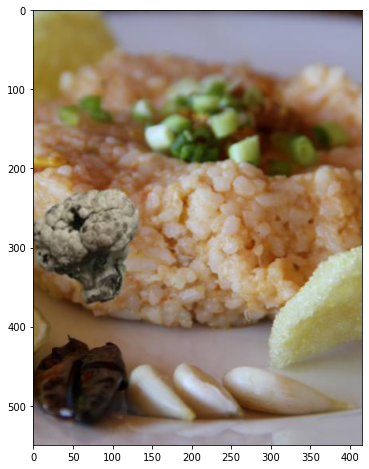

/content/tensorflow-object-detection-faster-rcnn/data/valid/83_jpg.rf.443435c25218491d3f625c935a26880f.jpg


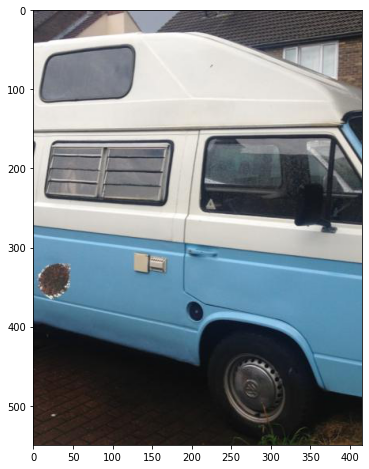

/content/tensorflow-object-detection-faster-rcnn/data/valid/183_jpg.rf.f933e811b5d61374b8558bf134aa02fd.jpg


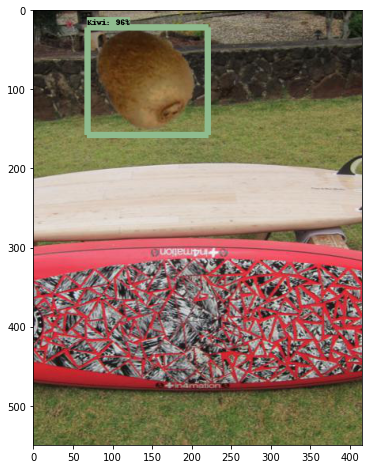

/content/tensorflow-object-detection-faster-rcnn/data/valid/710_jpg.rf.5862741b9723238b64f8a24fc4d8cded.jpg


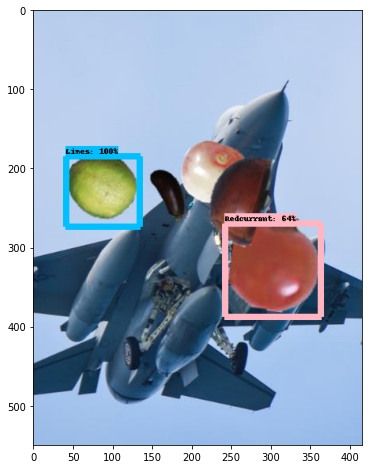

/content/tensorflow-object-detection-faster-rcnn/data/valid/273_jpg.rf.98454589fafbc198ed4907a02e7504d5.jpg


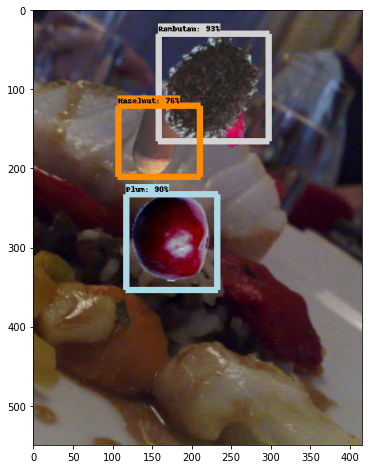

In [ ]:
for image_path in TEST_IMAGE_PATHS[:50]:
  try:
    image = Image.open(image_path)
    print(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)
    plt.show()
  except Exception:
    pass

In [ ]:
# get mAP of training set
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --checkpoint_dir={model_dir} \
    --model_dir='/content/eval' \
    --alsologtostderr \
    --run_once \
    --eval_training_data=True

W0517 23:40:44.380782 140111130113920 model_lib.py:812] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: None
I0517 23:40:44.381000 140111130113920 config_util.py:552] Maybe overwriting train_steps: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0517 23:40:44.381093 140111130113920 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
I0517 23:40:44.381180 140111130113920 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0517 23:40:44.381271 140111130113920 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0517 23:40:44.381383 140111130113920 model_lib.py:828] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
INFO:tensorflow:create_estimator_and_inputs: use_tpu False, export_to_t

# Visualise Results with Tensorboard

In [ ]:
%cd /content

!git clone https://github.com/tensorflow/tensorflow/

/content
Cloning into 'tensorflow'...
remote: Enumerating objects: 1149321, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 1149321 (delta 45), reused 53 (delta 23), pack-reused 1149201
Receiving objects: 100% (1149321/1149321), 678.11 MiB | 29.42 MiB/s, done.
Resolving deltas: 100% (937326/937326), done.
Checking out files: 100% (25009/25009), done.


In [ ]:
!python /content/tensorflow/tensorflow/python/tools/import_pb_to_tensorboard.py --model_dir /content/models/research/pretrained_model/saved_model/ --log_dir /tmp/tensorflow_logdir

2021-05-17 23:43:51.138832: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-05-17 23:43:51.145374: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-05-17 23:43:51.146075: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla T4 major: 7 minor: 5 memoryClockRate(GHz): 1.59
pciBusID: 0000:00:04.0
2021-05-17 23:43:51.146478: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-05-17 23:43:51.148448: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-05-17 23:43:51.156694: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2021-05-17 23:43:57--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 3.215.197.222, 34.233.212.111, 3.208.202.0, ...
Connecting to bin.equinox.io (bin.equinox.io)|3.215.197.222|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  43.3MB/s    in 0.3s    

2021-05-17 23:43:57 (43.3 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [ ]:
LOG_DIR = '/tmp/tensorflow_logdir'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [ ]:
get_ipython().system_raw('./ngrok http 6006 &')

In [ ]:
# run again
# in tensorboard, double click import module to view architecture
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
IndexError: list index out of range
